In [2]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
from helpers import *
import csv

%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [3]:
path_dataset = "47b05e70-6076-44e8-96da-2530dc2187de_data_train.csv"
path_submission = "9b4d32bb-f99a-466f-95a1-0ab80048971c_sample_submission (2).csv"
ratings = load_data(path_dataset)
ratings_=ratings.todense()#transform type from sparse matrix to np.array
submission = load_submission(path_submission)
submission_row_col = submission[0]
submission_pos = submission[1]
print(ratings.shape)
print(submission_pos[0])

number of items: 10000, number of users: 1000
(10000, 1000)
r37_c1


### Plot the number of ratings per movie and user

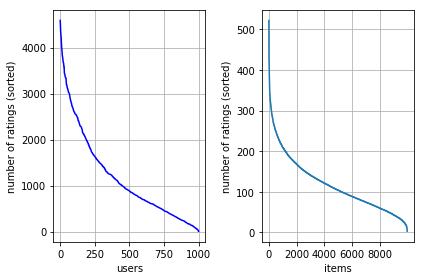

min # of items per user = 8, min # of users per item = 3.


In [4]:
from plots import *

num_items_per_user, num_users_per_item = plot_raw_data(ratings)
num_item, num_user = ratings.get_shape()

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Extract mean ratings for each user

In [5]:
def extract_user_mean(train,ratings):#maybe useful in prediction
    user_nnz = train.getnnz(axis=0)
    user_sum = train.sum(axis=0)
    user_mean = np.empty((1, num_user))
    for ind in range(num_user):
        user_mean[0,ind] = user_sum[0,ind] / user_nnz[ind]
        user_ind=ratings[:,ind]
        user_ind[user_ind==0]=user_mean[0,ind]
        ratings[:,ind]=user_ind
    return ratings

### Distance matrix

def build_distance_matrix(train, u):
    distance_list = []
    _, K= u.shape
    for k in range(K):
        sum_squares = np.sum(np.square(train.T - u[:, k]), axis=1)
        distance_list.append(sum_squares)
    return np.array(distance_list).T

### Initialization

In [7]:
def initialize_u(train,K):
    u_initial = (train.T[np.random.choice(num_user, K)]).T
    return u_initial


### Update z and u

In [98]:
def update_z(u,K,train):
    #nz_train, nz_item_userindices, nz_user_itemindices = build_index_groups(train)
    z = np.zeros((K,num_user))
    loss = []
    for n in range(num_user):#here
        inv = np.empty((1,K))
        valid_items,_ = np.where(train[:,n]>0)
        for k in range(K):
            inv[0,k] = np.mean(np.square(train[valid_items,n]-u[valid_items,k]))# this decide how we deal with zeros
        print(inv[0,:])
        znk=np.argmin(inv,axis=1)
        loss.append(np.min(inv)) 
        
        z[znk,n]=1
    return z,loss

def update_u(z,K,train):
    u = np.zeros((num_item,K))
    for k in range(K):
        sum=np.zeros((num_item,1))
        for n in range(num_user):
            sum+=z[k,n]*train[:,n]
        u[:,k]=sum[1]/np.sum((z[k,:]))
    return u



def update_kmeans_uz_parameters(train, u_old):
    D,_= train.shape
    _,K = u_old.shape
    z = np.zeros((K,num_user))
    distance_matrix = build_distance_matrix(train, u_old)
    losses = np.min(distance_matrix, axis=1)
    assignments = np.argmin(distance_matrix, axis=1)
    # update the u
    u = np.empty((num_item, K))
    for k in range(K):
        users = np.where(assignments == k)
        u[:,k] = np.mean(np.squeeze(train.T[users,:]), axis=0)
    return losses, assignments, np.nan_to_num(u)

In [ ]:
import copy
def kmeans_demo(ratings,ratings_):
    # init some empty lists to store the result.
    loss_list = []
    max_iters = 10
# K_range = [4,6,8,10,14,12,14,16,18,20,22,24]
    K=4
    threshold=1e-5
   # x_predict = np.zeros((num_item,num_user))
   # train= extract_user_mean(ratings,ratings2)
  #  for K in set(K_range):
    # initialize the cluster.
    u_old = initialize_u(ratings, K)
    u_old = u_old.toarray()
    
    # start the kmeans algorithm.
    for i in range(max_iters):
        # update z and mu
        z,loss = update_z(u_old,K,ratings_)
        u = update_u(z,K,ratings_)
        # calculate the average loss over all points
        average_loss = np.mean(loss)
        loss_list.append(average_loss)
        print("The current iteration of k-means is: {m}, the average loss is {l}.".format(m=i, l=average_loss))
        # check converge
        if i > 0 and np.abs(loss_list[-1] - loss_list[-2]) < threshold:
            break
        # output plot
       # print(len(u),u_old.shape[0])
        #plot_kmeans(train, u, u_old, output_figure + "kmean_iter{m}".format(m=i))
        # update k-means information.
        u_old = u
   # x_predict=x_predict+u.dot(z)
   # x_final=x_predict/len(K_range)
    return z,u

z,u = kmeans_demo(ratings,ratings_) 

[10.1616782  12.07979239 10.05062284 11.8333218 ]
[11.20945805 13.1128915  10.53875891 12.77369211]
[11.29269016 13.06116723 11.13256619 12.81671832]
[15.01158398 16.693469   14.69477997 16.51267379]
[11.39860678 13.54528238 11.24251593 13.30066231]
[19.85617675 22.26885553 19.74963947 21.99458193]
[11.18284343 12.90014691 10.98087664 12.70622839]
[14.80842853 16.52331984 14.56688492 16.33693063]
[8.74379085 9.6396386  8.59088812 9.48400615]
[13.04577881 14.70240545 12.85170775 14.43367597]
[10.80948863 12.11556904 10.59377454 11.99215091]
[ 9.80923077 11.11269231  9.32769231 10.89769231]
[10.86960744 12.73475207 10.54948347 12.24209711]
[18.0953951  20.24523816 17.93704911 19.98385644]
[ 9.74636563 10.97700491  9.56654719 10.88117506]
[11.23249484 12.84959818 10.8831616  12.76809614]
[7.81694367 8.44983758 7.7224179  8.39050309]
[6.66803561 7.00962968 6.52167612 6.99453944]
[11.30761481 13.11500247 10.8946963  12.79946667]
[8.92076695 9.71914062 8.70531994 9.67141314]
[12.26193504 13.

[13.97104313 16.56161807 13.91556309 16.32268119]
[13.16992454 15.29474057 13.14632782 15.07087501]
[17.05770688 19.35664314 16.43960368 18.98688931]
[ 9.29218813 10.20433182  8.8420144  10.20965809]
[12.33959421 14.31012588 11.87100643 14.03119494]
[13.20150574 15.03034798 12.05856535 14.67193016]
[ 8.88535836 10.18966429  8.59011148 10.02207688]
[16.95272282 19.41448498 17.00441539 19.11050224]
[13.95703569 16.01899821 13.04224184 15.73065972]
[18.88279579 20.91600524 18.67915617 20.65527646]
[11.85500289 13.37380809 11.52212866 13.21091333]
[ 9.08610126 10.57897352  9.29461809 10.55440176]
[12.65149724 14.09070815 12.48872949 13.95987278]
[11.03015592 12.18965336 10.83019518 12.04976689]
[12.37480274 13.95332865 12.21091638 13.76889635]
[13.12412208 14.55164811 12.98059717 14.43129254]
[ 9.15877228 10.17322242  8.53225286  9.91075334]
[13.17512025 14.51742929 12.9000836  14.34410278]
[11.35408693 12.56269553 10.37203334 12.41067118]
[15.60999864 17.8647488  15.40098057 17.5842286 ]


[14.01825506 16.39464656 13.18146237 15.85019543]
[12.72644094 15.37387219 12.1367719  14.9424133 ]
[14.57642403 16.8582906  14.45516246 16.67117627]
[12.64982164 15.30697582 12.62736161 14.85592549]
[13.88423015 16.3163836  13.78869296 16.04050141]
[13.27263706 15.27472138 13.04329442 15.09990375]
[ 9.5864665  10.70994183  9.30772002 10.638769  ]
[13.38901358 15.72367723 12.74843273 15.40072668]
[11.83576383 14.20812252 11.48635562 13.97794235]
[12.87318276 15.80738143 13.00795009 15.40186387]
[13.60666667 16.08751111 13.14262222 15.59337778]
[13.16155542 15.03018104 12.61531421 14.8371677 ]
[13.25390999 15.96149966 12.70427133 15.46578876]
[11.3126993  13.86001276 11.22297513 13.7061942 ]
[12.66118336 15.56841133 12.436373   14.97524565]
[14.53964536 17.64477456 14.26768506 17.2927988 ]
[13.63898232 15.65319562 13.44466115 15.44148855]
[15.61908776 17.42456531 15.09890102 17.17232832]
[16.09190297 18.45834807 15.76769901 18.17920395]
[14.3063549  16.33713469 14.02561456 16.05157231]


[13.31418125 15.22294056 12.6972326  14.9110026 ]
[10.31969991 11.83122348 10.3573336  11.71979245]
[14.81082816 16.78986091 14.67326768 16.5518885 ]
[8.31916955 9.97356401 8.70629758 9.77730104]
[13.51179684 16.12808376 13.71781332 15.9636605 ]
[14.77146008 17.79171907 14.8805196  17.50104819]
[7.36165955 7.75119363 7.29073847 7.74425349]
[ 8.92817729 10.34318263  8.44602172  9.96782663]
[8.11029412 8.33823529 7.44117647 8.11764706]
[10.45032986 11.59676409  9.84683293 11.47512203]
[6.2600802  6.43840499 6.21318779 6.65259523]
[13.6744956  16.09719188 13.51660889 15.89586751]
[13.09634322 15.93570899 13.00036386 15.51374499]
[ 9.08421223 10.4047872   8.4265843  10.17389132]
[10.96400012 12.27696885 10.62728974 12.20192828]
[10.019168 12.204192 10.003872 11.637408]
[ 9.19117647 10.22621107  8.38019031 10.17863322]
[10.65243648 12.68034152  9.68334953 11.95175621]
[12.01047008 13.6294955  10.76144717 12.92839471]
[ 9.29338843 12.18135904  8.78833792 10.98117539]
[11.59688793 13.86434664

[17.77327773 20.05383797 17.57637347 19.73658498]
[15.14861133 17.86337248 15.26953446 17.58759182]
[15.6173955  18.42743594 15.70773935 18.06256248]
[11.16434844 13.07525689 11.05988978 12.94017422]
[15.71935972 18.06941339 15.54213821 17.72040204]
[18.67296313 21.01583424 18.59785304 20.70378184]
[13.90591794 16.00666496 13.58488699 15.7113987 ]
[15.11705652 17.84473364 15.24555165 17.47710925]
[12.93080718 15.51735017 12.85006144 15.0186482 ]
[13.75609417 15.74078643 13.65572193 15.37390041]
[13.75050454 15.73409218 13.54222872 15.45646515]
[15.37082216 17.96192993 15.48313502 17.64529386]
[13.59559259 15.91238114 13.47167533 15.58867758]
[16.10456509 18.29820261 15.76772794 17.9283247 ]
[12.02595385 14.42848641 11.80251934 13.92091516]
[13.4412671  16.2133469  13.65218227 15.69896667]
[12.85309583 14.51801648 12.25107418 14.35620976]
[14.53540406 16.61390725 14.1685985  16.37282462]
[15.06941263 17.9688466  15.02192138 17.65356935]
[15.83710962 18.81640685 16.29090378 18.40275201]


[10.12274931 11.36964018  9.59080679 11.16931412]
[11.54503529 13.23066132 11.12265073 12.81200965]
[11.68607122 13.45595602 11.02737019 13.15498057]
[11.06497918 13.6736796   9.78749361 13.05913507]
[10.30553055 11.57101505 10.06393345 11.45442861]
[8.95688676 9.88770357 9.11166519 9.73494508]
[ 9.07730897 10.22947866  8.73910995 10.05862843]
[11.84660921 13.78865567 11.75970454 13.45715318]
[10.42687608 12.99594507 10.9997567  12.61083478]
[13.18633143 15.89234286 13.02454857 15.48886857]
[10.88420623 12.86619431 10.16939167 12.7203077 ]
[12.5596118  14.48281669 11.93111832 14.1500993 ]
[13.60266363 16.31038843 12.95118635 15.86833911]
[ 9.63033426 11.94437839 10.08904743 11.66138195]
[12.72548948 14.75610701 11.90895381 14.27966843]
[14.22229426 17.15894833 14.06905836 16.91833465]
[11.51579143 13.81982764 11.06513733 13.5496063 ]
[12.47299113 15.46023694 12.51990952 15.01472498]
[13.53472279 15.4984769  13.19287494 15.35269777]
[8.73373829 9.73309228 8.36030915 9.55154577]
[10.3393

[12.55989765 14.45315139 12.31407902 14.187531  ]
The current iteration of k-means is: 0, the average loss is 11.806047078057516.
[ 8.87092736 12.54411765  9.07705293 12.54411765]
[ 9.49832387 13.31638418  9.71339034 13.31638418]
[ 9.48924483 13.28661616  9.70303445 13.28661616]
[12.55246001 16.88969659 12.79956832 16.88969659]
[ 9.85352402 13.74094932 10.07287147 13.74094932]
[17.19365787 22.4205199  17.49567092 22.4205199 ]
[ 9.35701515 13.11032028  9.56808515 13.11032028]
[12.43606212 16.70299647 12.67883162 16.70299647]
[6.78223109 9.88627451 6.9532308  9.88627451]
[10.86629773 14.85736079 11.09204136 14.85736079]
[ 8.74046766 12.2912041   8.93903578 12.2912041 ]
[ 7.98298573 11.44230769  8.17591206 11.44230769]
[ 9.45971778 13.25227273  9.67321014 13.25227273]
[15.49748381 20.4164576  15.78049502 20.4164576 ]
[ 7.76292355 11.15400844  7.95163851 11.15400844]
[ 9.38871536 13.12395709  9.59867054 13.12395709]
[5.77789949 8.59121299 5.93095631 8.59121299]
[4.58845749 7.09654179 4.722

[12.42155563 16.81488801 12.67212599 16.81488801]
[11.31021163 15.46828225 11.54626241 15.46828225]
[14.73686798 19.55458196 15.01362977 19.55458196]
[ 7.32942413 10.57590759  7.50921477 10.57590759]
[10.50939704 14.48228713 10.7340191  14.48228713]
[11.16297362 15.33367037 11.39980365 15.33367037]
[ 7.23219304 10.52402746  7.41478259 10.52402746]
[14.80903112 19.63163033 15.08609441 19.63163033]
[12.00781992 16.28453307 12.25119293 16.28453307]
[16.0643777  21.06557734 16.35246362 21.06557734]
[ 9.76118135 13.58215385  9.97642755 13.58215385]
[ 7.47949059 10.80080214  7.66389937 10.80080214]
[10.36469702 14.29253731 10.58653875 14.29253731]
[ 8.82158976 12.35794276  9.01927018 12.35794276]
[10.24250054 14.15725594 10.46353471 14.15725594]
[10.74613758 14.74501109 10.97236324 14.74501109]
[ 7.49213936 10.78443114  7.67475713 10.78443114]
[10.69776378 14.65700966 10.92154376 14.65700966]
[ 9.22770242 12.93354943  9.43584345 12.93354943]
[13.49232929 18.06339946 13.75386904 18.06339946]


[12.2343928  16.6133829  12.48407801 16.6133829 ]
[11.40991167 15.58679707 11.64712364 15.58679707]
[ 7.70693042 11.03561644  7.89179433 11.03561644]
[11.79541981 16.0197775  12.03556161 16.0197775 ]
[10.49714054 14.48803828 10.72287396 14.48803828]
[11.77036226 16.04995005 12.01391268 16.04995005]
[12.02034691 16.33       12.26575287 16.33      ]
[11.20298893 15.37924866 11.44016229 15.37924866]
[11.9797659  16.28463476 12.22487659 16.28463476]
[10.17759266 14.11160714 10.39981544 14.11160714]
[11.5611125  15.82101167 11.8034478  15.82101167]
[13.37800886 17.97253433 13.64099619 17.97253433]
[11.75974962 15.98244214 11.99978865 15.98244214]
[13.13038712 17.60678571 13.38608406 17.60678571]
[14.01022515 18.65967742 14.27660238 18.65967742]
[12.23367949 16.55313765 12.47969058 16.55313765]
[12.67064493 17.07800752 12.92208119 17.07800752]
[11.08110656 15.27529412 11.31938636 15.27529412]
[6.63184041 9.69655172 6.80041267 9.69655172]
[ 7.0465781  10.3         7.22679696 10.3       ]
[ 7.

In [ ]:
test_point=np.array((submission_row_col))
submission_=np.empty((len(submission_pos)))
for test_ in test_point:
    i=0
    d,n=test_
    K = (np.where(z[:,n])==1)[0]
    group_users = (np.where (z[K,:]==1))[1]
    group_ratings=ratings_[d,:]
    group_valid_ratings = group_ratings(np.where(group_ratings)>0)
    counts=np.bincount(group_valid_ratings)
    max_=max(counts)
    submission_[i]=np.mean(np.where(counts==max_))
    i=i+1
    

In [ ]:
create_csv_submission(submission_pos, submission_, "kmeans.csv")

In [92]:
c = np.mean(np.square(a-a))

In [93]:
c

0.0